### Imports

In [10]:
import argparse
from inspect import currentframe, getframeinfo
from glob import glob
from pathlib import Path
import os
from os.path import join
import pandas as pd
import pickle
import sys

import numpy as np

import nibabel as nib
from nistats.first_level_model import FirstLevelModel
from nistats.design_matrix import make_first_level_design_matrix
from nistats.reporting import plot_design_matrix, plot_contrast_matrix

from utils.events_utils_nistats import get_beta_series, parse_EVs, process_confounds

### Parse Arguments
These are not needed for the jupyter notebook, but are used after conversion to a script for production

- conversion command:
  - jupyter nbconvert --to script --execute 1stlevel_analysis.ipynb

In [11]:
parser = argparse.ArgumentParser(description='Example BIDS App entrypoint script.')
parser.add_argument('-data_dir', default='/data')
parser.add_argument('-derivatives_dir', default=None)
parser.add_argument('-working_dir', default=None)
parser.add_argument('--subject_ids', nargs="+")
parser.add_argument('--tasks', nargs="+", help="Choose from ANT, CCTHot, discountFix, \
                                    DPX, motorSelectiveStop, stopSignal, \
                                    stroop, surveyMedley, twoByTwo, WATT3")
parser.add_argument('--skip_beta', action='store_false')
parser.add_argument('--skip_contrast', action='store_false')
parser.add_argument('--n_procs', default=16, type=int)
if '-derivatives_dir' in sys.argv or '-h' in sys.argv:
    args = parser.parse_args()
else:
    args = parser.parse_args([])
    args.data_dir = '/data'
    args.derivatives_dir = '/data/derivatives'
    args.tasks = ['stopSignal', 'stroop']
    args.subject_ids = ['s130']
    args.n_procs=4

### Initial Setup

In [12]:
# get current directory to pass to function nodes
filename = getframeinfo(currentframe()).filename
current_directory = str(Path(filename).resolve().parent)

# list of subject identifiers
subjects = args.subject_ids
# set task
tasks = args.tasks

#### Experiment Variables
derivatives_dir = args.derivatives_dir
fmriprep_dir = join(derivatives_dir, 'fmriprep', 'fmriprep')
data_dir = args.data_dir
first_level_dir = join(derivatives_dir,'1stlevel')
if args.working_dir is None:
    working_dir = join(derivatives_dir, '1stlevel_workingdir')
else:
    working_dir = join(args.working_dir, '1stlevel_workingdir')
run_beta = args.skip_beta
run_contrast = args.skip_contrast
n_procs = args.n_procs
# TR of functional images
TR = .68

In [13]:
# print
print('*'*79)
print('Tasks: %s\n, Subjects: %s\n, derivatives_dir: %s\n, data_dir: %s' % 
     (tasks, subjects, derivatives_dir, data_dir))
print('Running Contrast?: %s, Running Beta?: %s' % 
     (['No','Yes'][run_contrast], ['No','Yes'][run_beta]))
print('*'*79)

*******************************************************************************
Tasks: ['stopSignal', 'stroop']
, Subjects: ['s130']
, derivatives_dir: /data/derivatives
, data_dir: /data
Running Contrast?: Yes, Running Beta?: Yes
*******************************************************************************


# Set up Nodes

### Define helper functions

In [14]:
def get_func_file(fmriprep_dir, subject_id, task):
    # strip "sub" from beginning of subject_id if provided
    subject_id = subject_id.replace('sub-','')
    
    # get mask_file
    func_file = glob(join(fmriprep_dir,
                          'sub-%s' % subject_id,
                          '*', 'func',
                          '*%s*MNI*preproc.nii.gz' % task))
    
    # get mask_file
    mask_file = glob(join(fmriprep_dir,
                          'sub-%s' % subject_id,
                          '*', 'func',
                          '*%s*MNI*brainmask.nii.gz' % task))
    if not func_file or not mask_file:
        return None, None
    return func_file[0], mask_file[0]

def get_confounds(fmriprep_dir, subject_id, task):
    # strip "sub" from beginning of subject_id if provided
    subject_id = subject_id.replace('sub-','')
    
    ## Get the Confounds File (output of fmriprep)
    # Read the TSV file and convert to pandas dataframe
    confounds_file = glob(join(fmriprep_dir,
                               'sub-%s' % subject_id,
                               '*', 'func',
                               '*%s*confounds.tsv' % task))[0]
    regressors, regressor_names = process_confounds(confounds_file)
    confounds = pd.DataFrame(regressors, columns=regressor_names)
    return confounds
    
def get_events(data_dir, subject_id, task):
    ## Get the Events File if it exists
    # Read the TSV file and convert to pandas dataframe
    event_file = glob(join(data_dir,
                           'sub-%s' % subject_id,
                           '*', 'func',
                           '*%s*events.tsv' % task))[0]   
    events_df = pd.read_csv(event_file,sep = '\t')
    return events_df

def get_paradigm(EV_dict):
    # convert nipype format to nistats paradigm
    conditions = []
    onsets = []
    amplitudes = []
    durations = []
    for i in range(len(EV_dict['conditions'])):
        onset = EV_dict['onsets'][i]
        onsets += onset
        # add on conditions
        conditions += [EV_dict['conditions'][i]]*len(onset)
        duration = EV_dict['durations'][i]
        # add on duration, and extend if the array has a length of one
        if len(duration) == 1 and len(onset) > 1:
            duration *= len(onset)
        durations += duration
        # add on amplitude, and extend if the array has a length of one
        amplitude = EV_dict['amplitudes'][i]
        if len(amplitude) == 1 and len(onset) > 1:
            amplitude *= len(onset)
        amplitudes += amplitude
    paradigm = {'trial_type': conditions,
               'onset': onsets,
               'modulation': amplitudes,
               'duration': durations} 
    paradigm = pd.DataFrame(paradigm).sort_values(by='onset').reset_index()
    return paradigm

def create_design(events, confounds, task, beta=True):
    if beta:
        EV_dict = get_beta_series(events, regress_rt=False)
    else:
        EV_dict = parse_EVs(events, task, regress_rt=False)
    paradigm = get_paradigm(EV_dict)
    # make design
    n_scans = confounds.shape[0]
    design = make_first_level_design_matrix(np.arange(n_scans)*TR,
                               paradigm,
                               drift_model='cosine',
                               add_regs=confounds.values,
                               add_reg_names=list(confounds.columns))
    return design

def get_contrasts(task, design_matrix):
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])
    if task == 'ANT':
        contrasts = [('congruent', 'congruent'),
                    ('orienting_network', 'spatial-double'),
                    ('conflict_network', 'incongruent-congruent')]
        
    elif task == 'stroop':
        contrasts = [('congruent', 'congruent'),
                    ('stroop', 'incongruent-congruent')]
    
    elif task == 'stopSignal':
        contrasts = [('go', 'go'),
                    ('stop_success-go', 'stop_success-go'),
                     ('stop_failure-go', 'stop_failure-go'),
                     ('stop_success-stop_failure', 'stop_success-stop_failure'),
                     ('stop_failure-stop_success', 'stop_failure-stop_success')]
    if 'response_time' in design_matrix:
        contrasts.append(('RT','response_time'))
    return contrasts

### Visualization helper functions

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
from nilearn import plotting


def plot_design(subj):
    fig, ax = plt.subplots(figsize=(15,8))
    plot_design_matrix(subj.design, ax=ax, rescale=True)

    for name, contrast in subj.contrasts:
        ax=plot_contrast_matrix(contrast, design_matrix=subj.design)
        ax.set_xlabel(name)

def plot_contrast(subjinfo, contrast, **kwargs):
    if type(contrast) == int:
        contrast = subjinfo.contrasts[contrast]
        contrast_title = contrast[0]
        z_map = subjinfo.fit_model.compute_contrast(contrast[1])
    else:
        contrast_title = contrast
        z_map = subjinfo.fit_model.compute_contrast(contrast)
    default_args = {'threshold': norm.isf(0.001), 
                    'display_mode': 'ortho'}
    default_args.update(**kwargs)
    plotting.plot_glass_brain(z_map, colorbar=True, 
                          title=contrast_title,
                          plot_abs=False, **default_args)

Class to hold analysis output

In [16]:
from collections import namedtuple
SubjInfo = namedtuple('subjinfo', ['func','mask','design','contrasts','ID'])
class FirstLevel():
    def __init__(self, func, mask, design, contrasts, ID):
        self.func = func
        self.mask = mask
        self.design = design
        self.contrasts = contrasts
        self.ID = ID
        # once analysis has been run
        self.fit_model = None
        self.maps = {}
    
    def get_subjinfo(self):
        return SubjInfo(self.func, 
                        self.mask, 
                        self.design, 
                        self.contrasts, 
                        self.ID)

### Run analysis

In [17]:
to_run = []
for subject_id in subjects:
    for task in tasks:
        func_file, mask_file = get_func_file(fmriprep_dir, subject_id, task)
        if func_file is None or mask_file is None:
            print("Missing files for %s: %s" % (subject_id, task))
            continue
        events = get_events(data_dir, subject_id, task)
        confounds = get_confounds(fmriprep_dir, subject_id, task)
        design = create_design(events, confounds, task, beta=False)
        contrasts = get_contrasts(task, design)
        subjinfo = FirstLevel(func_file, mask_file, design, contrasts, '%s_%s' % (subject_id, task))
        subjinfo.event_file = events
        to_run.append(subjinfo)

Run model fit

In [18]:
"""
compare to things I did before:
high pass filter (80hz)
model_serial_correlations
should I mask? Don't think it matters
"""

for subjinfo in to_run:
    fmri_glm = FirstLevelModel(TR, 
                           noise_model='ar1',
                           standardize=False, 
                           hrf_model='spm',
                           drift_model='cosine',
                           period_cut=80,
                           smoothing_fwhm=4.4, # remove when doing this for real?
                          )
    out = fmri_glm.fit(subjinfo.func, design_matrices=subjinfo.design)
    subjinfo.fit_model = out

Create zmaps

In [ ]:
for subjinfo in to_run:
    for name, contrast in subjinfo.contrasts:
        z_map = subjinfo.fit_model.compute_contrast(contrast, output_type='z_score')
        subjinfo.maps[name+'_zscore'] = z_map

/usr/local/miniconda/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/usr/local/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


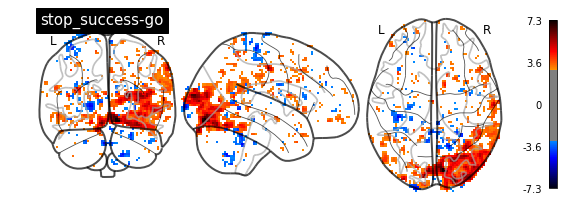

In [19]:
plot_contrast(to_run[0], 'stop_success-go')

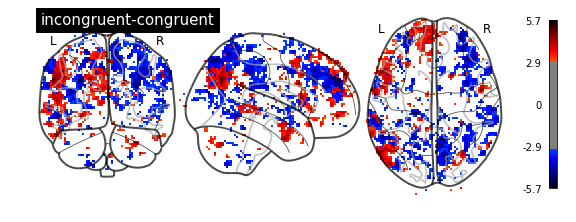

In [20]:
plot_contrast(to_run[1], 'incongruent-congruent', threshold=3)

In [ ]:
subjinfo = to_run[2]
for i in range(len(subjinfo.contrasts)):
    plot_contrast(subjinfo, i)